# Molecular Analysis and Validation

This notebook analyzes the relationship between PROTON's learned embeddings and molecular structures (via Uni-Mol2).
It performs the following steps:
1. Loads drug nodes and their PROTON embeddings.
2. Loads/Computes molecular properties (MW, LogP, etc.) from SMILES.
3. Loads pre-computed Uni-Mol2 embeddings for the drugs.
4. Uses a trained Adapter to project Uni-Mol2 embeddings into PROTON space.
5. Compares the "Adapted" embeddings with the "Original" PROTON embeddings using Cosine Similarity and UMAP.

In [24]:
import logging
import os
import sys
from pathlib import Path

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import umap
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Scaffolds import MurckoScaffold

# Setup Logging
logging.basicConfig(level=logging.INFO)
_logger = logging.getLogger("molecular_analysis")

def _find_repo_root(start: Path) -> Path:
    """Find PROTON-GEM root by walking up to `pyproject.toml`."""
    start = start.resolve()
    for parent in (start, *start.parents):
        if (parent / "pyproject.toml").exists():
            return parent
    return start

# Set Project Root
current_path = Path.cwd()
PROJECT_ROOT = _find_repo_root(current_path)
os.chdir(PROJECT_ROOT)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    
print(f"Project Root: {PROJECT_ROOT}")

# Import project modules
from src.config import conf
from src.constants import TORCH_DEVICE

# Load Secrets
try:
    from dotenv import load_dotenv
    if load_dotenv:
        load_dotenv(conf.paths.secrets_path)
except Exception as e:
    print(f"Could not load dotenv: {e}")

# Matplotlib settings
if any("Arial" in f.name for f in fm.fontManager.ttflist):
    plt.rcParams["font.family"] = "Arial"

Project Root: /Users/an583/Documents/Zitnik_Lab/PROTON-GEM


In [2]:
# Output directories (from config)
OUTPUT_DIR = conf.paths.notebooks.base_dir / conf.paths.notebooks.molecular_analysis.output_dir
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Cache file paths
SMILES_CACHE_PATH = conf.paths.kg.base_dir / conf.paths.kg.smiles_cache
UNIMOL_CACHE_PATH = OUTPUT_DIR / conf.paths.notebooks.molecular_analysis.unimol_cache
ADAPTER_PATH = conf.paths.checkpoint.base_dir / conf.paths.checkpoint.molecular_adapter

print(f"Output Directory: {OUTPUT_DIR}")

Output Directory: data/notebooks/molecular_analysis


In [3]:
class MolecularAdapter(nn.Module):
    """MLP adapter to map Uni-Mol2 molecular representations to PROTON embedding space."""
    def __init__(
        self,
        input_dim: int = 512,
        hidden_dim: int = 512,
        output_dim: int = 512,
        num_layers: int = 2,
        dropout: float = 0.1,
    ):
        super().__init__()
        layers = []
        # Input layer
        layers.extend([
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
        ])
        # Hidden layers
        for _ in range(num_layers - 1):
            layers.extend([
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.GELU(),
                nn.Dropout(dropout),
            ])
        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

## Load Data
Load nodes and pre-computed PROTON embeddings. Filter for `drug` nodes.

In [4]:
# Load nodes and embeddings
_logger.info("Loading nodes and embeddings...")
nodes = pd.read_csv(conf.paths.kg.nodes_path, dtype={"node_index": int}, low_memory=False)
embeddings = torch.load(conf.paths.checkpoint.embeddings_path)

# Filter to drug nodes
drug_nodes = nodes[nodes["node_type"] == "drug"].copy().reset_index(drop=True)
_logger.info(f"Number of drug nodes: {len(drug_nodes)}")

[02/03/26 15:41:13] INFO     Loading nodes and embeddings...                                         ]8;id=670532;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/174549191.py\174549191.py]8;;\:]8;id=150009;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/174549191.py#2\2]8;;\

[02/03/26 15:41:14] INFO     Number of drug nodes: 8160                                              ]8;id=391616;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/174549191.py\174549191.py]8;;\:]8;id=77538;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/174549191.py#8\8]8;;\

## Process SMILES
Load cached SMILES strings. Calculate molecular properties (MW, LogP, TPSA, Scaffold) if missing.

In [5]:
# 3. Load SMILES (Assume cached)
if not SMILES_CACHE_PATH.exists():
    _logger.error(f"SMILES cache not found at {SMILES_CACHE_PATH}. Run molecular_analysis.py first.")
    # In a notebook we might want to fail gracefully or give more instructions
    print(f"ERROR: {SMILES_CACHE_PATH} is missing.")
    
drug_smiles_df = pd.read_csv(SMILES_CACHE_PATH, dtype={"node_index": int})

# Check for properties and calculate if missing
props_to_check = ['MW', 'clogp', 'tpsa', 'scaffold_cluster']
if not all(col in drug_smiles_df.columns for col in props_to_check):
    _logger.info("One or more molecular properties missing. Calculating...")
    mw_list, logp_list, tpsa_list, scaffold_list = [], [], [], []
    
    # Calculate properties for all molecules in the cache
    for smi in tqdm(drug_smiles_df["SMILES"], desc="Calculating properties"):
        if pd.isna(smi) or not isinstance(smi, str):
            mw_list.append(None)
            logp_list.append(None)
            tpsa_list.append(None)
            scaffold_list.append(None)
            continue
            
        mol = Chem.MolFromSmiles(smi)
        if not mol:
            mw_list.append(None)
            logp_list.append(None)
            tpsa_list.append(None)
            scaffold_list.append(None)
            continue
            
        mw_list.append(Descriptors.MolWt(mol))
        logp_list.append(Descriptors.MolLogP(mol))
        tpsa_list.append(Descriptors.TPSA(mol))
        
        try:
            core = MurckoScaffold.GetScaffoldForMol(mol)
            scaffold_list.append(Chem.MolToSmiles(core))
        except Exception:
            scaffold_list.append(None)
            
    if 'MW' not in drug_smiles_df.columns:
        drug_smiles_df['MW'] = mw_list
    if 'clogp' not in drug_smiles_df.columns:
        drug_smiles_df['clogp'] = logp_list
    if 'tpsa' not in drug_smiles_df.columns:
        drug_smiles_df['tpsa'] = tpsa_list
    if 'scaffold_cluster' not in drug_smiles_df.columns:
        # Cluster scaffolds by assigning IDs to unique scaffold SMILES
        codes, _ = pd.factorize(pd.Series(scaffold_list))
        drug_smiles_df['scaffold_cluster'] = codes
        
    drug_smiles_df.to_csv(SMILES_CACHE_PATH, index=False)
    _logger.info(f"Updated {SMILES_CACHE_PATH} with calculated properties.")

valid_drugs_df = drug_smiles_df[drug_smiles_df["SMILES"].notna()].copy().reset_index(drop=True)
_logger.info(f"Drugs with valid SMILES: {len(valid_drugs_df)}")

# Get corresponding PROTON embeddings for valid drugs
valid_drug_indices = valid_drugs_df["node_index"].values
valid_drug_embeddings = embeddings[valid_drug_indices]

                    INFO     One or more molecular properties missing. Calculating...              ]8;id=295285;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/2941865914.py\2941865914.py]8;;\:]8;id=886193;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/2941865914.py#12\12]8;;\

Calculating properties:   0%|          | 0/8160 [00:00<?, ?it/s]

[15:41:17] Explicit valence for atom # 7 Cl, 5, is greater than permitted


[02/03/26 15:41:18] INFO     Updated data/neurokg/drugs/drug_smiles.csv with calculated            ]8;id=860852;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/2941865914.py\2941865914.py]8;;\:]8;id=396933;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/2941865914.py#54\54]8;;\
                             properties.                                                                           

                    INFO     Drugs with valid SMILES: 6944                                         ]8;id=240907;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/2941865914.py\2941865914.py]8;;\:]8;id=654797;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/2941865914.py#57\57]8;;\

## Load Uni-Mol2 and Project Embeddings
Load the pre-computed Uni-Mol2 embeddings and project them into the PROTON embedding space using the trained adapter.

In [ ]:
# Load Uni-Mol2 embeddings (assume cached)
if not UNIMOL_CACHE_PATH.exists():
    _logger.error(f"Uni-Mol2 cache not found at {UNIMOL_CACHE_PATH}. Run molecular_analysis.py first.")
    
unimol_data = torch.load(UNIMOL_CACHE_PATH)
if isinstance(unimol_data, dict):
    unimol_embeddings = unimol_data["embeddings"]
    valid_indices = unimol_data["valid_indices"]
else:
    unimol_embeddings = unimol_data
    valid_indices = list(range(len(unimol_embeddings)))

# Filter targets if necessary
if len(valid_indices) < len(valid_drug_embeddings):
    _logger.warning("Mismatch in encoded molecules vs valid drugs. Aligning...")
    # This logic assumes valid_indices maps to the indices in `valid_drugs_df` which is already filtered by SMILES validity.
    # We must ensure we slice everything consistently.
    valid_drug_embeddings = valid_drug_embeddings[valid_indices]
    valid_drugs_df = valid_drugs_df.iloc[valid_indices].reset_index(drop=True)

# Load adapter
if not ADAPTER_PATH.exists():
     _logger.error(f"Adapter checkpoint not found at {ADAPTER_PATH}. Run molecular_analysis.py first.")

checkpoint = torch.load(ADAPTER_PATH, map_location=TORCH_DEVICE)
adapter = MolecularAdapter(
    input_dim=checkpoint["input_dim"],
    hidden_dim=checkpoint["hidden_dim"],
    output_dim=checkpoint["output_dim"],
    num_layers=checkpoint["num_layers"],
)
adapter.load_state_dict(checkpoint["model_state_dict"])
adapter = adapter.to(TORCH_DEVICE)
adapter.eval()

# Compute projected embeddings
_logger.info("Projecting embeddings...")
with torch.no_grad():
    adapted_embeddings = adapter(unimol_embeddings.to(TORCH_DEVICE)).cpu()

print(f"Adapted embeddings shape: {adapted_embeddings.shape}")
print(f"Target PROTON embeddings shape: {valid_drug_embeddings.shape}")

                    WARNING  Mismatch in encoded molecules vs valid drugs. Aligning...             ]8;id=647092;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/3255433988.py\3255433988.py]8;;\:]8;id=22194;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/3255433988.py#15\15]8;;\

                    INFO     Projecting embeddings...                                              ]8;id=944117;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/3255433988.py\3255433988.py]8;;\:]8;id=169838;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/3255433988.py#37\37]8;;\

Adapted embeddings shape: torch.Size([6943, 512])
Target PROTON embeddings shape: torch.Size([6943, 512])


## Cosine Similarity Analysis
Compute the cosine similarity between the adapted molecular embeddings and the original network-based PROTON embeddings.

[02/03/26 17:49:47] INFO     Computing cosine similarity...                                          ]8;id=952635;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/612649402.py\612649402.py]8;;\:]8;id=464226;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/612649402.py#2\2]8;;\

                    INFO     Plotting distribution...                                               ]8;id=596251;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/612649402.py\612649402.py]8;;\:]8;id=651194;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/612649402.py#11\11]8;;\

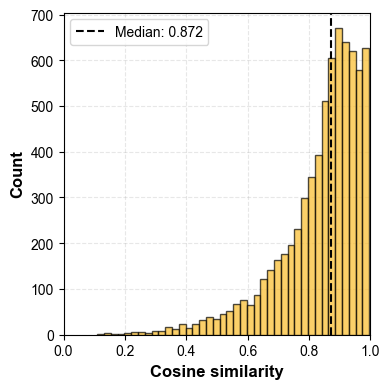

[02/03/26 17:49:48] INFO     Plot saved to                                                          ]8;id=799787;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/612649402.py\612649402.py]8;;\:]8;id=217881;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/612649402.py#33\33]8;;\
                             data/notebooks/molecular_analysis/cosine_similarity_distribution                      

Stats:
Mean: 0.8369
Median: 0.8724
Std: 0.1353
Min: 0.1096
Max: 0.9964


In [88]:
# Compute cosine similarity
_logger.info("Computing cosine similarity...")
cosine_similarities = F.cosine_similarity(
    adapted_embeddings, valid_drug_embeddings, dim=1
).numpy()

# Add to dataframe
valid_drugs_df["cosine_similarity"] = cosine_similarities

# Plot distribution
_logger.info("Plotting distribution...")
fig, ax = plt.subplots(figsize=(4, 4))

mean_val = cosine_similarities.mean()
median_val = np.median(cosine_similarities)
std_val = cosine_similarities.std()

ax.hist(cosine_similarities, bins=40, color="#fabc2a", edgecolor="black", alpha=0.7, zorder=3)
ax.axvline(median_val, color="black", linestyle="--", 
           label=f"Median: {median_val:.3f}", zorder=4)

ax.set_xlabel("Cosine similarity", fontsize=12, fontweight="bold")
ax.set_ylabel("Count", fontsize=12, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3, linestyle="--", zorder=0)
ax.set_xlim(0, 1)

output_path = OUTPUT_DIR / "cosine_similarity_distribution"
plt.tight_layout()
plt.savefig(str(output_path) + ".png", bbox_inches="tight", dpi=300)
plt.savefig(str(output_path) + ".svg", bbox_inches="tight", dpi=300)
plt.show() # Show in notebook
_logger.info(f"Plot saved to {output_path}")

print(f"Stats:\nMean: {mean_val:.4f}\nMedian: {median_val:.4f}\nStd: {std_val:.4f}\nMin: {cosine_similarities.min():.4f}\nMax: {cosine_similarities.max():.4f}")

## UMAP Visualization
Project both original and adapted embeddings into 2D space using UMAP to visualize the structural correspondence.

[02/03/26 16:32:32] INFO     Loading cached UMAP coordinates from                                    ]8;id=263615;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py\831641868.py]8;;\:]8;id=241736;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py#5\5]8;;\
                             data/notebooks/molecular_analysis/umap_embeddings.pt...                               

                    INFO     UMAP coordinates loaded from cache.                                     ]8;id=778967;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py\831641868.py]8;;\:]8;id=561894;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py#9\9]8;;\

                    INFO     Plotting UMAPs...                                                      ]8;id=226895;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py\831641868.py]8;;\:]8;id=774483;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py#75\75]8;;\

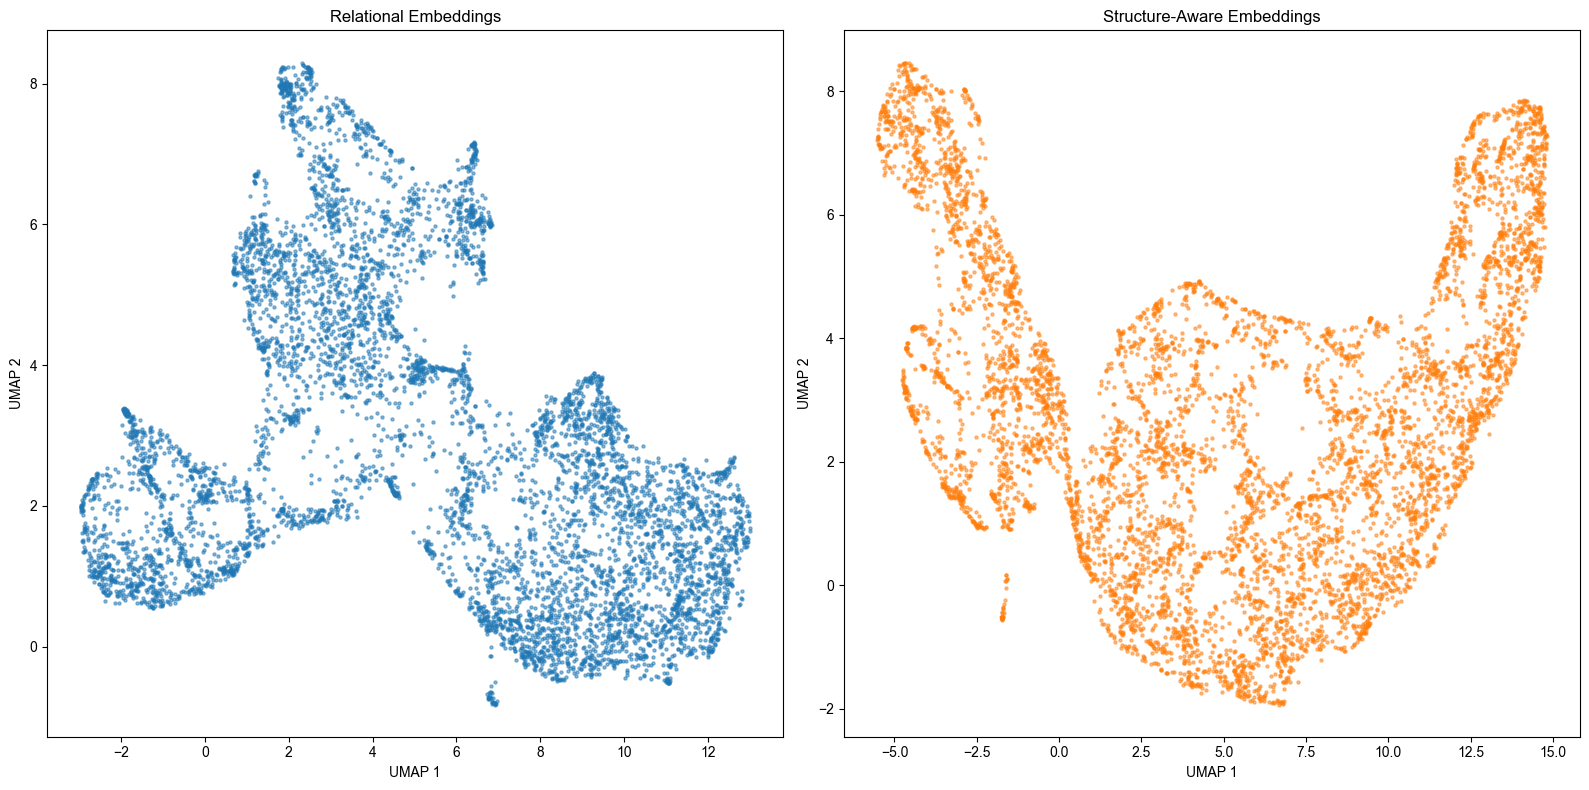

[02/03/26 16:32:33] INFO     Plotting UMAPs colored by MW...                                       ]8;id=550121;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py\831641868.py]8;;\:]8;id=625780;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py#101\101]8;;\

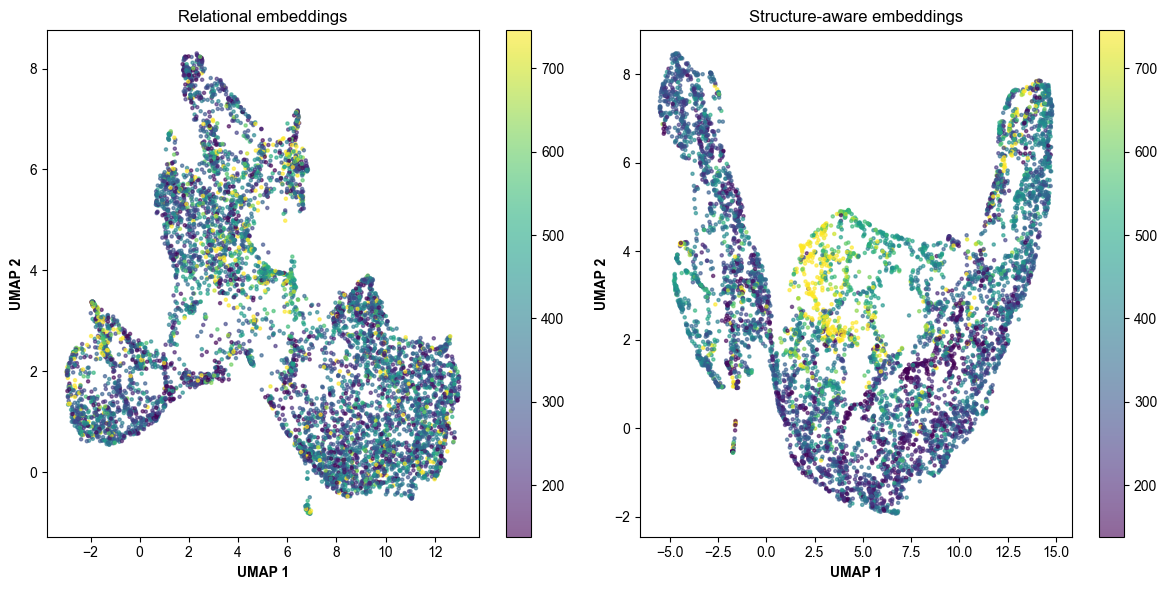

[02/03/26 16:32:35] INFO     UMAP plot saved to                                                     ]8;id=238533;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py\831641868.py]8;;\:]8;id=378411;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py#72\72]8;;\
                             data/notebooks/molecular_analysis/umap_comparison_mw.png                              

                    INFO     Plotting UMAPs colored by clogp...                                    ]8;id=560081;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py\831641868.py]8;;\:]8;id=132731;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py#101\101]8;;\

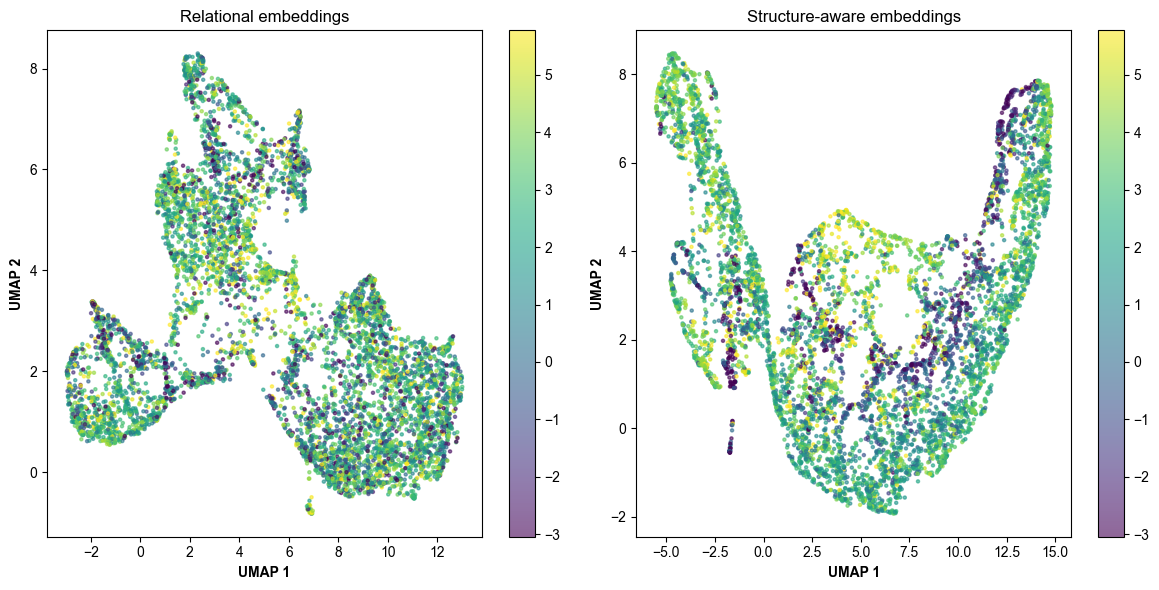

[02/03/26 16:32:36] INFO     UMAP plot saved to                                                     ]8;id=306327;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py\831641868.py]8;;\:]8;id=731295;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py#72\72]8;;\
                             data/notebooks/molecular_analysis/umap_comparison_clogp.png                           

                    INFO     Plotting UMAPs colored by tpsa...                                     ]8;id=789359;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py\831641868.py]8;;\:]8;id=514723;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py#101\101]8;;\

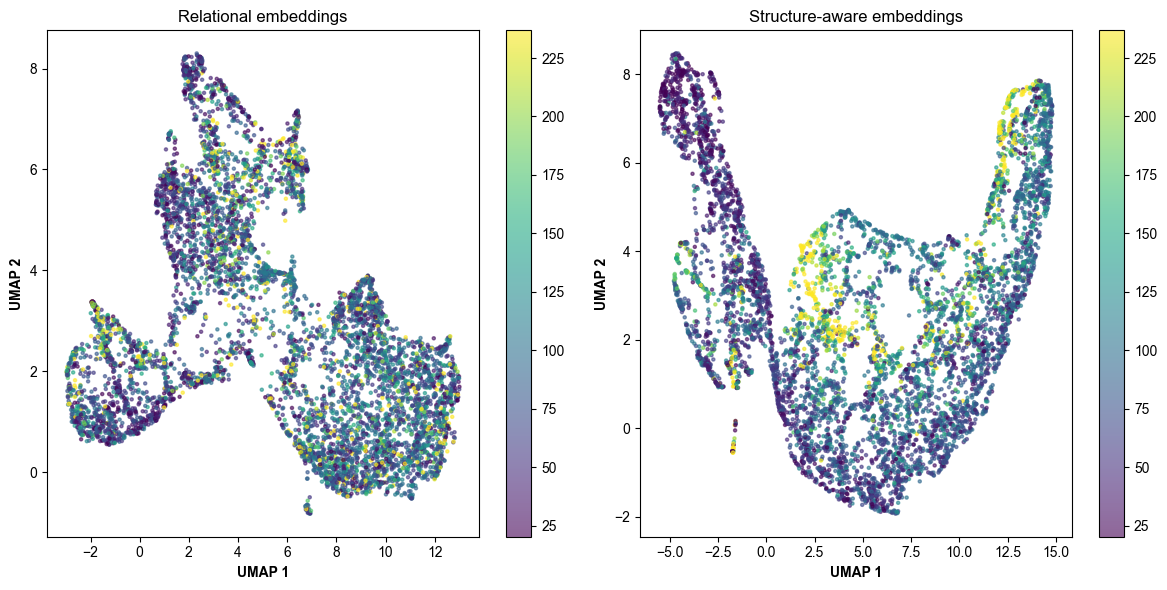

[02/03/26 16:32:37] INFO     UMAP plot saved to                                                     ]8;id=298151;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py\831641868.py]8;;\:]8;id=492198;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py#72\72]8;;\
                             data/notebooks/molecular_analysis/umap_comparison_tpsa.png                            

                    INFO     Plotting UMAPs colored by scaffold_cluster...                         ]8;id=53872;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py\831641868.py]8;;\:]8;id=264742;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py#101\101]8;;\

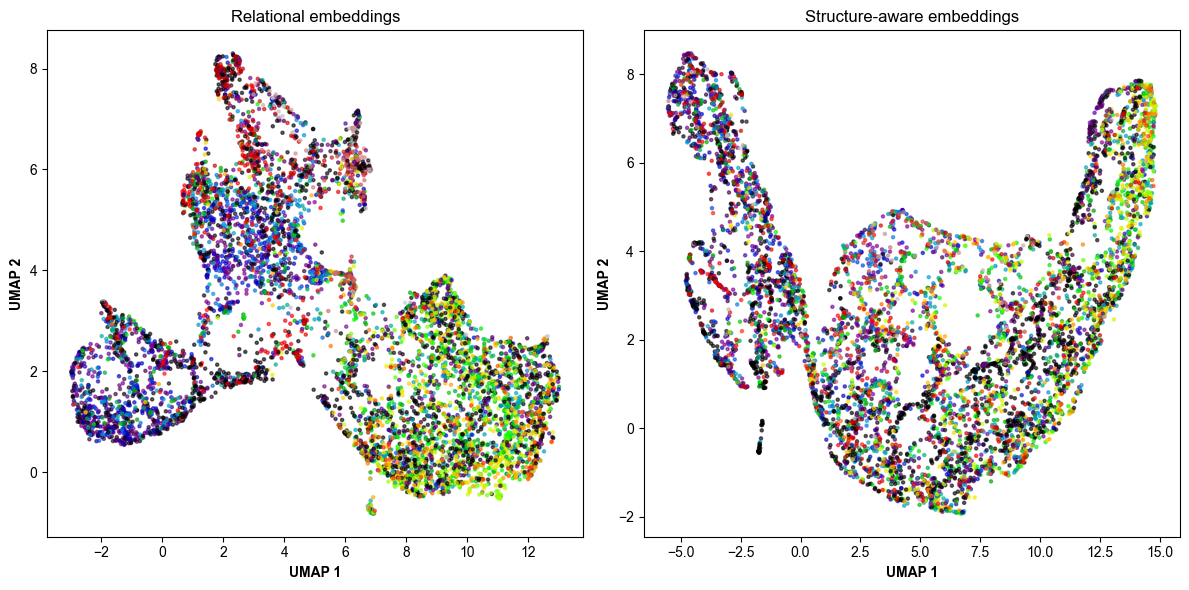

[02/03/26 16:32:39] INFO     UMAP plot saved to                                                     ]8;id=862050;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py\831641868.py]8;;\:]8;id=68517;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/831641868.py#72\72]8;;\
                             data/notebooks/molecular_analysis/umap_comparison_scaffold_cluster.png                

In [86]:
# Check for cached UMAP coordinates
UMAP_CACHE_PATH = OUTPUT_DIR / conf.paths.notebooks.molecular_analysis.umap_cache

if UMAP_CACHE_PATH.exists():
    _logger.info(f"Loading cached UMAP coordinates from {UMAP_CACHE_PATH}...")
    umap_cache = torch.load(UMAP_CACHE_PATH)
    original_umap = umap_cache["original_umap_coords"]
    adapted_umap = umap_cache["adapted_umap_coords"]
    _logger.info("UMAP coordinates loaded from cache.")
else:
    _logger.info("No UMAP cache found. Computing UMAPs...")

    # Convert to numpy if tensors
    original_embs_np = valid_drug_embeddings.detach().cpu().numpy()
    adapted_embs_np = adapted_embeddings.detach().cpu().numpy()
        
    reducer = umap.UMAP(random_state=42)

    # Fit and transform
    # Note: fitting separate UMAPs to see independent structure
    _logger.info("Running UMAP on Original Embeddings...")
    original_umap = reducer.fit_transform(original_embs_np)

    _logger.info("Running UMAP on Adapted Embeddings...")
    reducer_adapter = umap.UMAP(random_state=42) 
    adapted_umap = reducer_adapter.fit_transform(adapted_embs_np)

    # Save UMAP cache immediately after computation
    _logger.info(f"Saving UMAP cache to {UMAP_CACHE_PATH}...")
    torch.save({
        "original_umap_coords": original_umap,
        "adapted_umap_coords": adapted_umap,
    }, UMAP_CACHE_PATH)

def plot_umap_pair(color_vals, title_suffix, cmap='viridis', is_categorical=False):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Handle NaNs
    mask = ~pd.isna(color_vals)
    if not mask.all():
         _logger.warning(f"NaN values found for {title_suffix}, plotting subset.")
    
    # Range
    vmin, vmax = None, None
    if not is_categorical:
        s = pd.Series(color_vals[mask])
        if not s.empty:
            vmin = s.quantile(0.05)
            vmax = s.quantile(0.95)
            
    # Original
    sc1 = axes[0].scatter(original_umap[mask, 0], original_umap[mask, 1], 
                          s=5, alpha=0.6, c=color_vals[mask], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Relational embeddings")
    axes[0].set_xlabel("UMAP 1", fontweight="bold")
    axes[0].set_ylabel("UMAP 2", fontweight="bold")
    if not is_categorical:
        plt.colorbar(sc1, ax=axes[0])
    
    # Adapted
    sc2 = axes[1].scatter(adapted_umap[mask, 0], adapted_umap[mask, 1], 
                          s=5, alpha=0.6, c=color_vals[mask], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1].set_title(f"Structure-aware embeddings")
    axes[1].set_xlabel("UMAP 1", fontweight="bold")
    axes[1].set_ylabel("UMAP 2", fontweight="bold")
    if not is_categorical:
        plt.colorbar(sc2, ax=axes[1])
    
    plt.tight_layout()
    # Sanitize filename
    safe_suffix = title_suffix.replace(" ", "_").replace("(", "").replace(")", "").lower()
    if safe_suffix:
        output_path = OUTPUT_DIR / f"umap_comparison_{safe_suffix}.png"
    else:
        output_path = OUTPUT_DIR / "umap_comparison.png"
        
    plt.savefig(output_path, bbox_inches="tight", dpi=300)
    plt.show()
    _logger.info(f"UMAP plot saved to {output_path}")

# Plot 1: Blue/Orange (Default) - using constant color logic or just plain scatter
_logger.info("Plotting UMAPs...")
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Original
axes[0].scatter(original_umap[:, 0], original_umap[:, 1], s=5, alpha=0.5, c='#1f77b4')
axes[0].set_title("Relational Embeddings")
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")

# Adapted
axes[1].scatter(adapted_umap[:, 0], adapted_umap[:, 1], s=5, alpha=0.5, c='#ff7f0e')
axes[1].set_title("Structure-Aware Embeddings")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")

plt.tight_layout()
output_path = OUTPUT_DIR / "umap_comparison"
plt.savefig(str(output_path) + ".png", bbox_inches="tight", dpi=300)
plt.savefig(str(output_path) + ".svg", bbox_inches="tight", dpi=300)
plt.show()
plt.close(fig)

# Plot by properties
properties = ['MW', 'clogp', 'tpsa', 'scaffold_cluster']
for prop in properties:
    if prop in valid_drugs_df.columns:
        _logger.info(f"Plotting UMAPs colored by {prop}...")
        vals = valid_drugs_df[prop].values
        
        is_categorical = (prop == 'scaffold_cluster')
        cmap = 'nipy_spectral' if is_categorical else 'viridis'
        
        plot_umap_pair(vals, f"({prop})", cmap=cmap, is_categorical=is_categorical)

In [83]:
def plot_scaffold_umap(color_vals, original_umap, adapted_umap, palette_colors=None):
    """
    Optimized plotting for scaffold clusters. 
    Top 10 largest clusters are renamed 1-10 in the legend, 
    followed by 'Others'.
    """
    import pandas as pd
    from collections import Counter

    # 1. Identify the top 10 clusters by frequency (Size-based order)
    counts = Counter(color_vals[~pd.isna(color_vals)])
    top_10_tuples = counts.most_common(10)
    
    # top_10_clusters contains the ACTUAL original cluster IDs in order of size
    top_10_clusters = [cluster for cluster, count in top_10_tuples]
    cluster_to_count = dict(top_10_tuples)

    # 2. Setup custom palette
    if palette_colors is None:
        palette = sns.color_palette("husl", 10)
    else:
        palette = palette_colors
        
    color_map = {cluster: palette[i] for i, cluster in enumerate(top_10_clusters)}

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), facecolor='white')
    titles = ["Relational embeddings", "Structure-aware embeddings"]
    coords = [original_umap, adapted_umap]
    
    for i, ax in enumerate(axes):
        ax.grid(True, linestyle='--', alpha=0.3, zorder=0)
        
        mask_top_10 = np.array([val in color_map for val in color_vals])
        
        # Plot "Others" (Background) first
        ax.scatter(
            coords[i][~mask_top_10, 0], coords[i][~mask_top_10, 1],
            s=12, alpha=0.2, c='lightgray', edgecolors='none', zorder=1, label="Others"
        )

        # Plot Top 10 in size-based frequency order
        # Use 'enumerate' to rename them 1-10 in the legend
        for idx, cluster in enumerate(top_10_clusters):
            mask = (color_vals == cluster)
            ax.scatter(
                coords[i][mask, 0], coords[i][mask, 1],
                s=18, alpha=0.9, c=[color_map[cluster]], 
                edgecolors='none', zorder=2, 
                label=f"Cluster {idx + 1} (n={cluster_to_count[cluster]})"
            )
        
        ax.set_title(titles[i], fontsize=14, fontweight="bold", pad=15)
        ax.set_xlabel("UMAP 1", fontsize=12)
        ax.set_ylabel("UMAP 2", fontsize=12)
        sns.despine(ax=ax)

    # 3. Handle legend reordering (Move "Others" to the end)
    handles, labels = axes[1].get_legend_handles_labels()
    
    # Find "Others" (it was added first in the loop, so usually index 0)
    others_idx = labels.index("Others")
    others_handle = handles.pop(others_idx)
    others_label = labels.pop(others_idx)
    
    # Append it to the end
    handles.append(others_handle)
    labels.append(others_label)

    fig.legend(
        handles, labels, 
        loc='lower center', 
        bbox_to_anchor=(0.5, -0.02), 
        ncol=6, 
        fontsize=10, 
        frameon=False
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25) # Extra space for the bottom legend
    
    output_path = OUTPUT_DIR / "umap_scaffold_clusters.png"
    plt.savefig(output_path, bbox_inches="tight", dpi=300)
    plt.savefig(output_path.with_suffix(".svg"), bbox_inches="tight", dpi=300)
    plt.show()

[02/03/26 16:24:13] INFO     Plotting optimized scaffold cluster UMAPs...                           ]8;id=253080;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/1961090286.py\1961090286.py]8;;\:]8;id=755053;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_28099/1961090286.py#1\1]8;;\

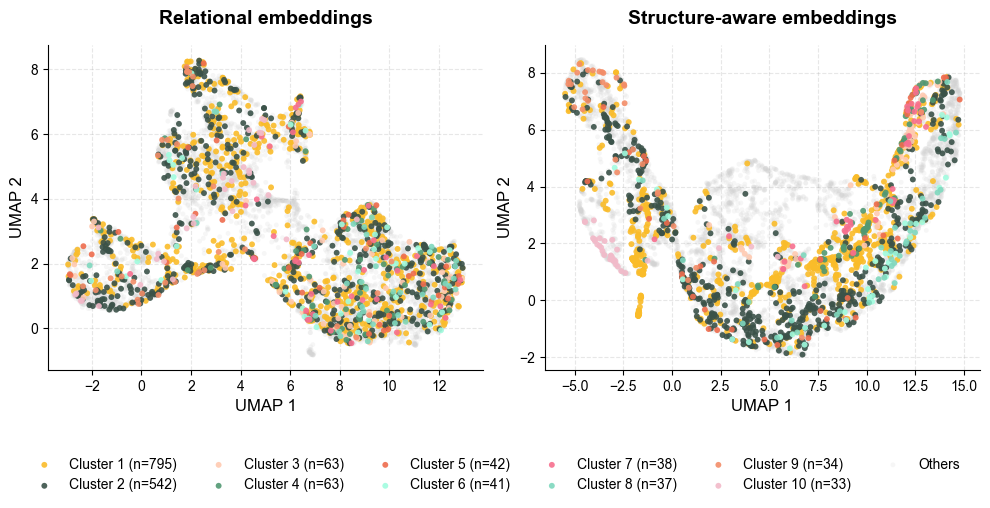

In [84]:
_logger.info("Plotting optimized scaffold cluster UMAPs...")
vals = valid_drugs_df['scaffold_cluster'].values


# my_colors = ["#f94144","#f3722c","#f8961e","#f9844a","#f9c74f","#90be6d","#43aa8b","#4d908e","#577590","#277da1"]
my_colors = [
    "#fabc2a",  # bright yellow
    "#3b5249",  # dark green
    "#ffcab1",  # pale peach
    "#519872",  # medium green
    "#ee6c4d",  # strong red-orange
    "#a1fcdf",  # light aqua
    "#f76f8e",  # pink
    "#7fd8be",  # mint
    "#f38d68",  # coral
    "#f2bac9",  # soft rose
]
plot_scaffold_umap(vals, original_umap, adapted_umap, palette_colors=my_colors)

## Save Results
Save the calculated cosine similarities and the embeddings used for UMAP visualization to disk.

In [9]:
# Save raw data
csv_path = OUTPUT_DIR / "cosine_similarities.csv"
valid_drugs_df.to_csv(csv_path, index=False)
_logger.info(f"Cosine similarities saved to {csv_path}")

# Save embeddings used for UMAP
# Saving as torch tensors or dictionary
umap_data_path = OUTPUT_DIR / "umap_embeddings.pt"
torch.save({
    "original_embeddings": valid_drug_embeddings.cpu(),
    "adapted_embeddings": adapted_embeddings.cpu(),
    "original_umap_coords": original_umap,
    "adapted_umap_coords": adapted_umap,
    "node_indices": valid_drugs_df["node_index"].values,
    "smiles": valid_drugs_df["SMILES"].values
}, umap_data_path)
_logger.info(f"UMAP embeddings saved to {umap_data_path}")

                    INFO     Cosine similarities saved to                                           ]8;id=100195;file:///tmp/ipykernel_4064466/3120414936.py\3120414936.py]8;;\:]8;id=876585;file:///tmp/ipykernel_4064466/3120414936.py#4\4]8;;\
                             data/molecular_analysis_results/cosine_similarities.csv                               

                    INFO     UMAP embeddings saved to                                              ]8;id=24535;file:///tmp/ipykernel_4064466/3120414936.py\3120414936.py]8;;\:]8;id=872916;file:///tmp/ipykernel_4064466/3120414936.py#17\17]8;;\
                             data/molecular_analysis_results/umap_embeddings.pt                                    